In [86]:
import gc, argparse, sys, os, errno
import numpy as np
import pandas as pd
import h5py
import os
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
import numpy as np # basic math and random numbers
import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
import torch.utils.data
from torch.autograd import Variable # storing data while learning
from scipy import stats
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils import data as utilsdata
import torch.nn.functional as F

In [170]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
import h5py
import os
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler,StandardScaler,MaxAbsScaler,RobustScaler

Populating the interactive namespace from numpy and matplotlib


In [6]:
cd ..

/home/chenxupeng/projects/DIP


In [8]:
ls bin/utils.py

bin/utils.py


In [15]:
#setup figure template
figure_template_path = 'bin'
if figure_template_path not in sys.path:
    sys.path.append(figure_template_path)
from importlib import reload
import figure_template, utils
#force reload of the module
reload(figure_template)
reload(utils)
from figure_template import display_dataframe, embed_pdf_figure, embed_pdf_pages,std_plot,legendhandle
from utils import prepare_dataset

In [18]:
def oneHotEncoding(y, numOfClasses):
    """
    Convert a vector into one-hot encoding matrix where that particular column value is 1 and rest 0 for that row.
    :param y: Label vector
    :param numOfClasses: Number of unique labels
    :return: one-hot encoding matrix
    """
    y = np.asarray(y, dtype='int32')
    if len(y) > 1:
        y = y.reshape(-1)
    if not numOfClasses:
        numOfClasses = np.max(y) + 1
    yMatrix = np.zeros((len(y), numOfClasses))
    yMatrix[np.arange(len(y)), y] = 1
    return yMatrix

In [168]:
X_train, y_train, X_test,  y_test,_,_ = prepare_dataset(datafile='data/BoW_Training.mat',valid_method = 'non-iid',
                                                      train_context_num=5)

(4156, 52)


In [172]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [173]:
#y_train = oneHotEncoding(y_train[:,0], 10)
#y_test = oneHotEncoding(y_test[:,0], 10)
y_train =y_train[:,0]
y_test =y_test[:,0]

### MLP

In [176]:
## network
class MLPNet(nn.Module):
    def __init__(self,n_input = 50,n_hidden_1 = 32,n_hidden_2 = 20,n_hidden_3 = 16,n_classes = 10):
        super(MLPNet, self).__init__()
        self.n_input  = n_input
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.fc1 = nn.Linear(n_input, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_hidden_3)
        self.out = nn.Linear(n_hidden_3, n_classes)
    def forward(self, x):
        x = x.view(-1, self.n_input)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.out(x))
        return torch.nn.functional.log_softmax(x)
        

    def name(self):
        return "MLP"

use_cuda = False
model =  MLPNet()
if use_cuda:
    model = model.cuda()

In [177]:
def train(epoch, model, train_loader, optimizer, log_interval=100, cuda=None,report=False):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)

        pred = output.data.max(1)[1] # get the index of the max log-probability
        #print (output.data,output.data.max(1),output.data.size(),target.data.size())
        correct += pred.eq(target.data).cpu().sum()
        accuracy =  float(correct) / float(len(train_loader.dataset))
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        #print (loss,loss.data)
        optimizer.step()
        if batch_idx % log_interval == 0:
            if report ==1:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Accuracy: ({:.4f})\n'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data.item(), accuracy))

def validate(loss_vector, accuracy_vector, model, validation_loader, cuda=None,report=False):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        val_loss += torch.nn.functional.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = float(correct) / float( len(validation_loader.dataset) )
    accuracy_vector.append(accuracy)
    if report ==1:
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f})\n'.format(
            val_loss, correct, len(validation_loader.dataset), accuracy))


In [178]:
def main(train_loader,validation_loader,LEARNING_RATES , MOMENTUM_RATES ,WEIGHT_DECAY_RATES,report_interval):
    cuda = torch.cuda.is_available()
    print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)



    hidden_nodes = 100
    layers = 1
    for i in tqdm(range(1, len(LEARNING_RATES) + 1)):
        if cuda:
            model.cuda()
        optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATES[0],momentum=MOMENTUM_RATES[0],weight_decay=WEIGHT_DECAY_RATES[0])

        loss_vector = []
        acc_vector = []
        
        for epoch in tqdm(range(1, EPOCHS + 1)):
            if epoch % report_interval ==0:
                report = 1
            else:
                report = 0 
            train(epoch, model, train_loader, optimizer, cuda=cuda,report=report)
            validate(loss_vector, acc_vector, model, validation_loader, cuda=cuda,report=report)
        # Plot train loss and validation accuracy vs epochs for each learning rate
        if PLOT:
            epochs = [i for i in range(1, 26)]
            plt.plot(np.arange(1,EPOCHS+1), acc_vector)

            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.show()

            plt.plot(np.arange(1,EPOCHS+1), loss_vector)
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.show()

In [179]:
LEARNING_RATES = [0.01]
MOMENTUM_RATES = [.9]
WEIGHT_DECAY_RATES = [.005]
batch_size = 20
PLOT = 1
EPOCHS = 400
# Dataloader

train_data = utilsdata.TensorDataset(torch.from_numpy(X_train.astype('float32')), torch.from_numpy(y_train.astype('int')))
test_data = utilsdata.TensorDataset(torch.from_numpy(X_test.astype('float32')), torch.from_numpy(y_test.astype('int')))
train_loader = torch.utils.data.DataLoader(
                                           dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(
                                          dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

Using PyTorch version: 1.0.0 CUDA: False


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

Train Epoch: 100 [0/2960 (0%)]	Loss: 1.814798 Accuracy: (0.0020)

Train Epoch: 100 [2000/2960 (68%)]	Loss: 1.790892 Accuracy: (0.2125)


Validation set: Average loss: 2.3668, Accuracy: 210/1196 (0.1756)

Train Epoch: 200 [0/2960 (0%)]	Loss: 1.755925 Accuracy: (0.0027)

Train Epoch: 200 [2000/2960 (68%)]	Loss: 1.757527 Accuracy: (0.2250)


Validation set: Average loss: 2.3726, Accuracy: 222/1196 (0.1856)

Train Epoch: 300 [0/2960 (0%)]	Loss: 1.847627 Accuracy: (0.0024)

Train Epoch: 300 [2000/2960 (68%)]	Loss: 1.816306 Accuracy: (0.2270)


Validation set: Average loss: 2.3776, Accuracy: 235/1196 (0.1965)

Train Epoch: 400 [0/2960 (0%)]	Loss: 1.694919 Accuracy: (0.0020)

Train Epoch: 400 [2000/2960 (68%)]	Loss: 1.931295 Accuracy: (0.2152)


Validation set: Average loss: 2.3860, Accuracy: 224/1196 (0.1873)



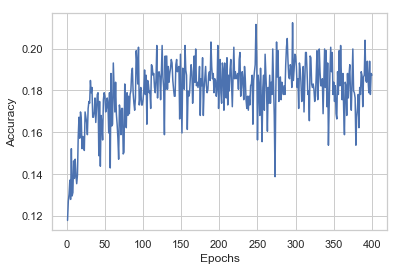

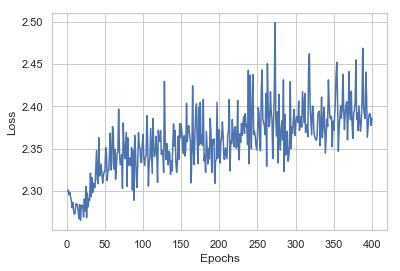

In [180]:
main(train_loader,test_loader,LEARNING_RATES , MOMENTUM_RATES ,WEIGHT_DECAY_RATES,report_interval = 100)

### logistic

In [182]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, \
    roc_curve, precision_recall_curve, average_precision_score, matthews_corrcoef, confusion_matrix

def report_metrics(y_test, y_pred):
    scorers = {'accuracy': accuracy_score(y_test, y_pred),
           'recall': recall_score(y_test, y_pred,average='weighted'),
           'precision': precision_score(y_test, y_pred,average='weighted'),
           'f1': f1_score(y_test, y_pred,average='weighted')
    }
    for metric in scorers.keys():
        print('{} = {}'.format(metric, scorers[metric]))


model = LogisticRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
report_metrics(y_test, y_pred)

accuracy = 0.16638795986622074
recall = 0.16638795986622074
precision = 0.16632199745782228
f1 = 0.16236441244542799


### attention

In [194]:
class MLP_feature_attention(nn.Module):
    '''
    attention with simple weight sharing
    
    '''
    def __init__(self, 
                 n_input = 50, n_hiddens = 32, n_hiddens_2 = 20,n_output = 10,):
        super(MLP_feature_attention, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_hiddens = np.atleast_1d(n_hiddens)


        layers_attention = []
        layers_attention.append(nn.Linear(n_input, n_input))
        layers_attention.append(nn.ReLU())
        layers_attention.append(nn.Linear(n_input, n_input))
        layers_attention.append(nn.Sigmoid())
        self.attention = nn.Sequential(*layers_attention)

        layers = []
        n_hidden_prev = n_input
        for n in self.n_hiddens:
            layers.append(nn.Linear(n_hidden_prev, n))
            layers.append(nn.ReLU())
            #layers.append(nn.Dropout())
            n_hidden_prev = n
        layers.append(nn.Linear(n_hidden_prev, n_hiddens_2 ))
        self.encoder = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=n_output)
    def forward(self, x):
        x_attention = self.attention(x)
        #print (x_attention.size())
        #x_attention = torch.cat((torch.clamp(x_attention[:,:self.feature_thres_ind],
          #                                   0,self.thres_cut),
             #                    x_attention[:,self.feature_thres_ind:]),1)

        x = torch.mul(x_attention,x).view(-1,self.n_input)
        x = self.encoder(x)
        
        return torch.nn.functional.log_softmax(x)
use_cuda = False
model =  MLP_feature_attention()
if use_cuda:
    model = model.cuda()

In [195]:
LEARNING_RATES = [0.01]
MOMENTUM_RATES = [.9]
WEIGHT_DECAY_RATES = [.005]
batch_size = 100
PLOT = 1
EPOCHS = 400
# Dataloader

train_data = utilsdata.TensorDataset(torch.from_numpy(X_train.astype('float32')), torch.from_numpy(y_train.astype('int')))
test_data = utilsdata.TensorDataset(torch.from_numpy(X_test.astype('float32')), torch.from_numpy(y_test.astype('int')))
train_loader = torch.utils.data.DataLoader(
                                           dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(
                                          dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

Using PyTorch version: 1.0.0 CUDA: False


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

Train Epoch: 100 [0/2960 (0%)]	Loss: 1.998157 Accuracy: (0.0105)


Validation set: Average loss: 2.3393, Accuracy: 201/1196 (0.1681)

Train Epoch: 200 [0/2960 (0%)]	Loss: 1.914695 Accuracy: (0.0111)


Validation set: Average loss: 2.3503, Accuracy: 217/1196 (0.1814)

Train Epoch: 300 [0/2960 (0%)]	Loss: 1.910921 Accuracy: (0.0125)


Validation set: Average loss: 2.3955, Accuracy: 215/1196 (0.1798)

Train Epoch: 400 [0/2960 (0%)]	Loss: 1.749672 Accuracy: (0.0145)


Validation set: Average loss: 2.3901, Accuracy: 220/1196 (0.1839)



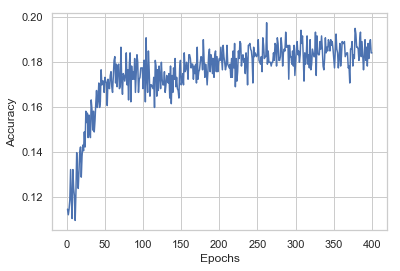

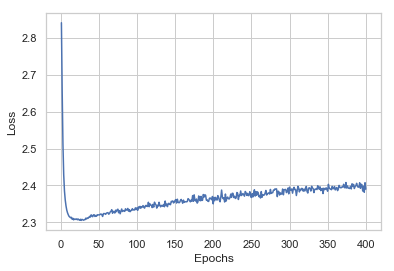

In [196]:
main(train_loader,test_loader,LEARNING_RATES , MOMENTUM_RATES ,WEIGHT_DECAY_RATES,report_interval = 100)

In [198]:
class MLP_sample_attention(nn.Module):
    '''
    attention with simple weight sharing
    
    '''
    def __init__(self, 
                 n_input = 50, n_hiddens = 32, n_hiddens_2 = 20,n_output = 10,):
        super(MLP_sample_attention, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_hiddens = np.atleast_1d(n_hiddens)


        layers_attention = []
        layers_attention.append(nn.Linear(n_input, n_input))
        layers_attention.append(nn.ReLU())
        layers_attention.append(nn.Linear(n_input, 1))
        layers_attention.append(nn.Sigmoid())
        self.attention = nn.Sequential(*layers_attention)

        layers = []
        n_hidden_prev = n_input
        for n in self.n_hiddens:
            layers.append(nn.Linear(n_hidden_prev, n))
            layers.append(nn.ReLU())
            #layers.append(nn.Dropout())
            n_hidden_prev = n
        layers.append(nn.Linear(n_hidden_prev, n_hiddens_2 ))
        self.encoder = nn.Sequential(*layers)
        #self.softmax = nn.Softmax(dim=n_output)
    def forward(self, x):
        x_attention = self.attention(x)
        #print (x_attention.size())
        #x_attention = torch.cat((torch.clamp(x_attention[:,:self.feature_thres_ind],
          #                                   0,self.thres_cut),
             #                    x_attention[:,self.feature_thres_ind:]),1)

        x = torch.mul(x_attention,x).view(-1,self.n_input)
        x = self.encoder(x)
        
        return torch.nn.functional.log_softmax(x)
use_cuda = False
model =  MLP_sample_attention()
if use_cuda:
    model = model.cuda()

In [203]:
LEARNING_RATES = [0.01]
MOMENTUM_RATES = [.9]
WEIGHT_DECAY_RATES = [.005]
batch_size = 2000
PLOT = 1
EPOCHS = 2000
# Dataloader

train_data = utilsdata.TensorDataset(torch.from_numpy(X_train.astype('float32')), torch.from_numpy(y_train.astype('int')))
test_data = utilsdata.TensorDataset(torch.from_numpy(X_test.astype('float32')), torch.from_numpy(y_test.astype('int')))
train_loader = torch.utils.data.DataLoader(
                                           dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(
                                          dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

Using PyTorch version: 1.0.0 CUDA: False


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Train Epoch: 100 [0/2960 (0%)]	Loss: 1.766583 Accuracy: (0.2551)


Validation set: Average loss: 2.4030, Accuracy: 227/1196 (0.1898)

Train Epoch: 200 [0/2960 (0%)]	Loss: 1.768756 Accuracy: (0.2537)


Validation set: Average loss: 2.4025, Accuracy: 228/1196 (0.1906)

Train Epoch: 300 [0/2960 (0%)]	Loss: 1.768731 Accuracy: (0.2605)


Validation set: Average loss: 2.4023, Accuracy: 228/1196 (0.1906)

Train Epoch: 400 [0/2960 (0%)]	Loss: 1.757259 Accuracy: (0.2642)


Validation set: Average loss: 2.4044, Accuracy: 226/1196 (0.1890)

Train Epoch: 500 [0/2960 (0%)]	Loss: 1.756067 Accuracy: (0.2632)


Validation set: Average loss: 2.4031, Accuracy: 230/1196 (0.1923)

Train Epoch: 600 [0/2960 (0%)]	Loss: 1.754642 Accuracy: (0.2591)


Validation set: Average loss: 2.4051, Accuracy: 228/1196 (0.1906)

Train Epoch: 700 [0/2960 (0%)]	Loss: 1.744951 Accuracy: (0.2618)


Validation set: Average loss: 2.4052, Accuracy: 228/1196 (0.1906)

Train Epoch: 800 [0/2960 (0%)]	Loss: 1.747049 Accuracy: (0.262

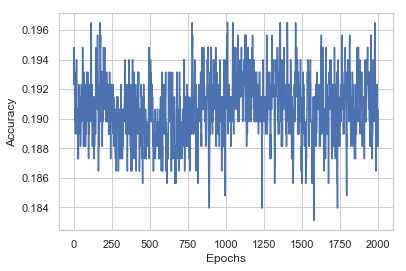

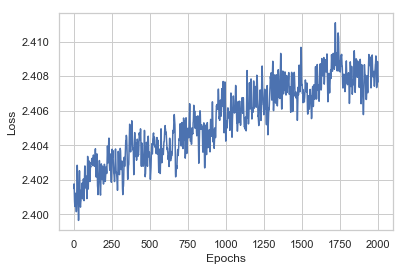

In [204]:
main(train_loader,test_loader,LEARNING_RATES , MOMENTUM_RATES ,WEIGHT_DECAY_RATES,report_interval = 100)

- [ ] add more regularization like CRLR in attention weight
    - [ ] feature level(above)
    - [ ] sample level (need to increase batch size a lot), try to implement CR

### CR attention

### MDN